# Multivariate forecasting with BART ridership

This notebook demonstrates a Pyro model for high-dimensional multivariate time series.

## Data

We analyze the [BART ridership dataset](https://www.bart.gov/about/reports/ridership), consisting of hourly rider counts between every pair of BART train stations over the years 2011-2018. There are 47 stations total, leading to 47**2 = 2209 individual time series of count data, ranging from 0 to around 2000 max.

## Create a model

Let's create a model that generalizes the HMM-VAE model from [Part III](https://pyro.ai/time/part_iii_dustom). Recall that our model consisted of a Hidden Markov Model whose observations are latent rates, and those latent rates generated Poisson observations. Here we will generalize to:
1. Generalize from [Poisson](http://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.Poisson) to [ZeroInflatedPoisson](http://docs.pyro.ai/en/stable/distributions.html#zeroinflatedpoisson) observations, requiring a latent `gate` in (0,1) and `rate` > 0.
2. Use a multivariate low-dimensional HMM state vector (typically 8-dimensional).
3. Use a diagonal noise distributoin over the high-dimensional `(gate,rate)` variables.
4. Use a more sophisticated guide by combining a diagonal guide component (i.e. per origin-destination pair) with a low rank neural component (i.e. among all pairs but with a bottleneck layer.
5. Instead of writing separate models for training and forecasting, we'll write a single model that includes logic from both. Note that both our `Model` and `Guide` are `nn.Module`s.

The full model and guide are in [forecast.py](https://github.com/pyro-ppl/sandbox/blob/master/2019-08-time-series/bart/forecast.py).


## Train the model

We'll train the model on an initial portion of the data. The entire dataset is 70128 hours, so we'll train on only 60k hours and compute 2-week running forecasts on the remaining hours.

To download data and train, run
```sh
python main.py --truncate=60000 --verbose  # takes ~30 minutes
```
```
      673 Training on 47 stations over 70128 hours, 209 batches/epoch
     1289 On average 39.4/47 stations are open at any one time
     1324 feature_dim = 215
     1983 step 0 loss = 18.22
     2422 guide.diag_part = tensor([-0.0500,  0.0500, -0.0500, -0.0500])
     2423 init scale min/mean/max: 9.95 9.95 9.95
     2423 trans scale min/mean/max: 0.0951 0.104 0.105
     2423 trans mat eig:
tensor([1.1043, 0.9433, 0.9398, 0.9398, 0.9160, 0.9103, 0.9103, 0.8900])
     3205 step 1 loss = 19.92
     3909 step 2 loss = 17.22
     4875 step 3 loss = 14.73
     ...
```

## Load the trained model

Now we can load our trained model (and the Pyro param store).

In [1]:
import torch
import pyro
import pyro.distributions as dist
from matplotlib import pyplot

%matplotlib inline
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}
pyro.enable_validation()
print(pyro.__version__)
print(torch.__version__)

0.4.0+ee86597d
1.2.0


In [2]:
pyro.get_param_store().load("pyro_param_store.pkl")
forecaster = torch.load("forecaster.pkl")
print(type(forecaster))
print(forecaster.dataset["stations"])

/Users/fritzobermeyer/miniconda2/envs/pyro3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'forecast.Model' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


<class 'forecast.Forecaster'>
['12TH', '16TH', '19TH', '24TH', 'ANTI', 'ASHB', 'BALB', 'BAYF', 'CAST', 'CIVC', 'COLM', 'COLS', 'CONC', 'DALY', 'DBRK', 'DELN', 'DUBL', 'EMBR', 'FRMT', 'FTVL', 'GLEN', 'HAYW', 'LAFY', 'LAKE', 'MCAR', 'MLBR', 'MONT', 'NBRK', 'NCON', 'OAKL', 'ORIN', 'PHIL', 'PITT', 'PLZA', 'POWL', 'RICH', 'ROCK', 'SANL', 'SBRN', 'SFIA', 'SHAY', 'SSAN', 'UCTY', 'WCRK', 'WDUB', 'WOAK', 'WSPR']


## Forecast foreward based on latest window

Let's draw a single sample from our forecaster. To do this, `Forecaster` uses pyro's `trace` and `replay` effect handlers internally, using the familiar pattern
```py
...
with poutine.trace() as tr:
    self.guide(features, counts)
with poutine.replay(trace=tr.trace):
    forecast = self.model(features, counts)
...
```
We'll simply call `forecaster()` to do this.

In [3]:
window_end = 60000  # tune HMM on lots of data
window_begin = window_end - 24 * 30  # predict from 1 month previous
forecast_hours = 24 * 7 * 2  # predict the following 2 weeks

forecast = forecaster(window_begin, window_end, forecast_hours)
print(forecast.shape)

torch.Size([336, 47, 47])


## Compare against truth

Let's compare our forecast with truth.

In [4]:
truth = forecaster.counts[window_end: window_end + forecast_hours]
print(truth.shape)

torch.Size([336, 47, 47])


In [5]:
print("Mean absolute error = {:0.3g}".format((truth - forecast).abs().mean()))

Mean absolute error = 5.83


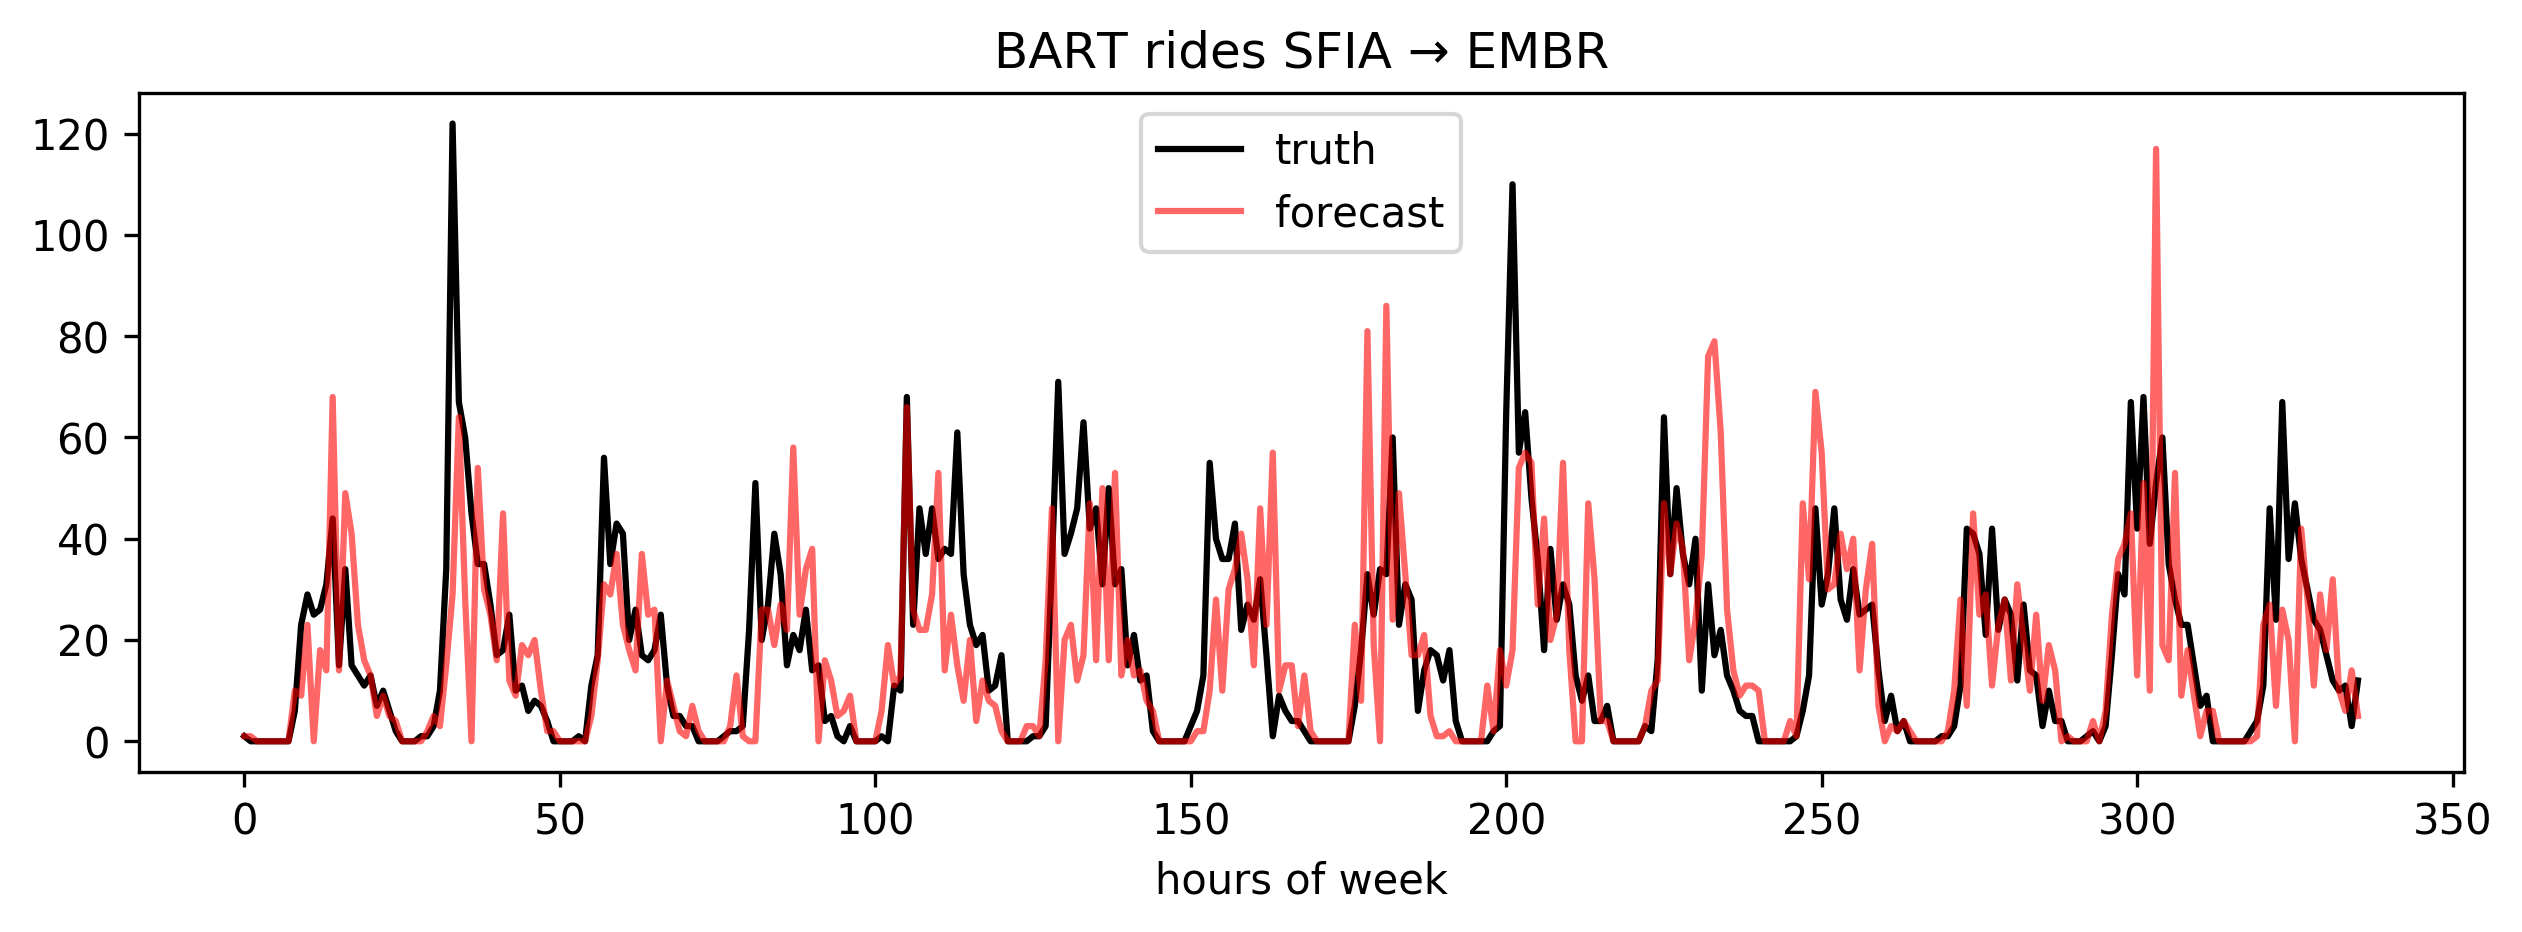

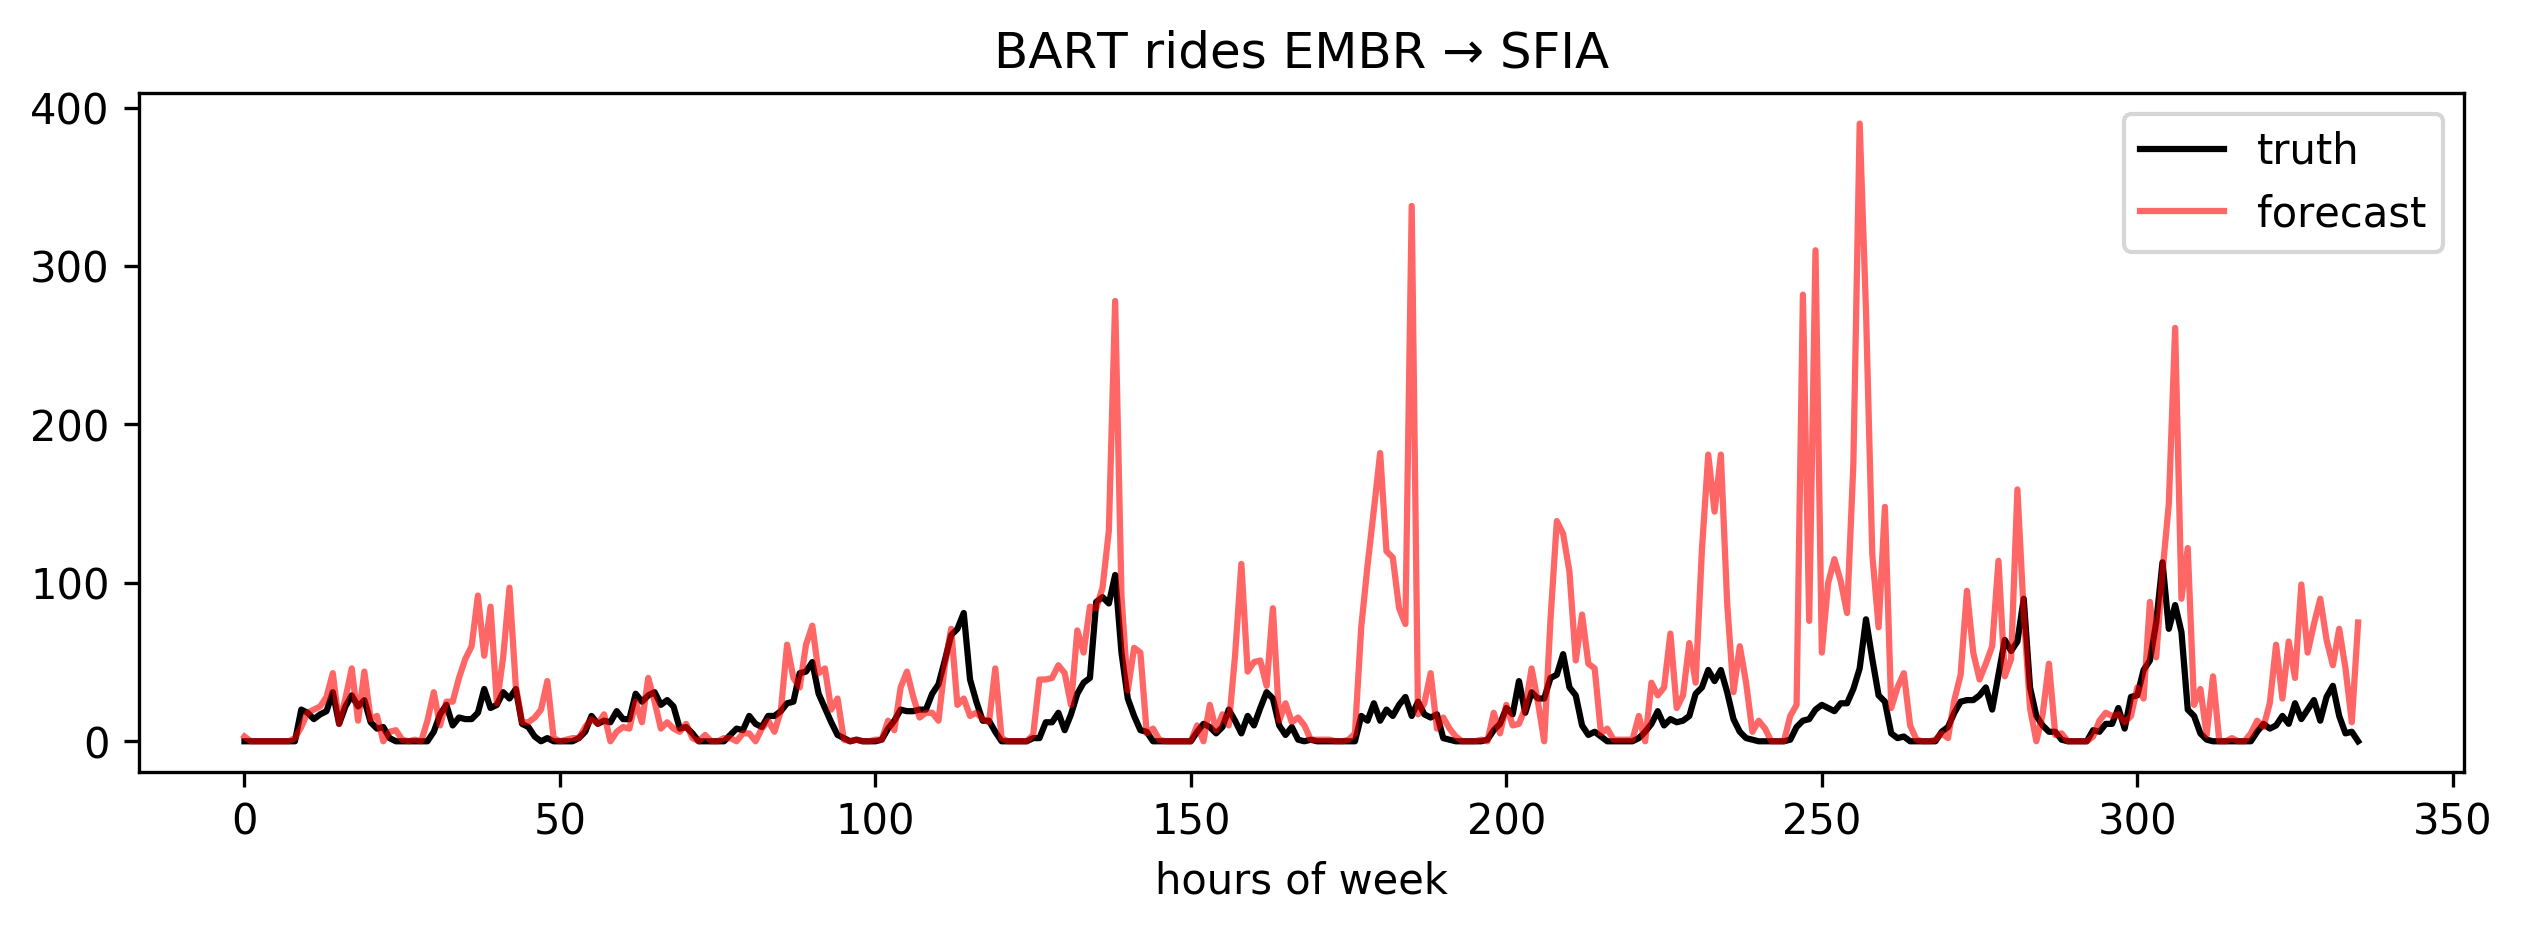

In [6]:
for origin, destin in [("SFIA", "EMBR"), ("EMBR", "SFIA")]:
    o = forecaster.dataset["stations"].index(origin)
    d = forecaster.dataset["stations"].index(destin)
    pyplot.figure(figsize=(10, 3), dpi=300)
    pyplot.plot(truth[:, o, d], 'k-', label="truth")
    pyplot.plot(forecast[:, o, d], 'r-', label="forecast", alpha=0.6)
    pyplot.xlabel("hours of week")
    pyplot.title("BART rides {} → {}".format(origin, destin))
    pyplot.legend();

## Next let's draw multiple samples

This will be a little slow, but remember we're simultaneously forecasting all 2209 pairs.

In [7]:
%%time
samples = forecaster(window_begin, window_end, forecast_hours, num_samples=100)
print(samples.shape)

torch.Size([100, 336, 47, 47])
CPU times: user 24.1 s, sys: 27.8 s, total: 51.8 s
Wall time: 1min 25s


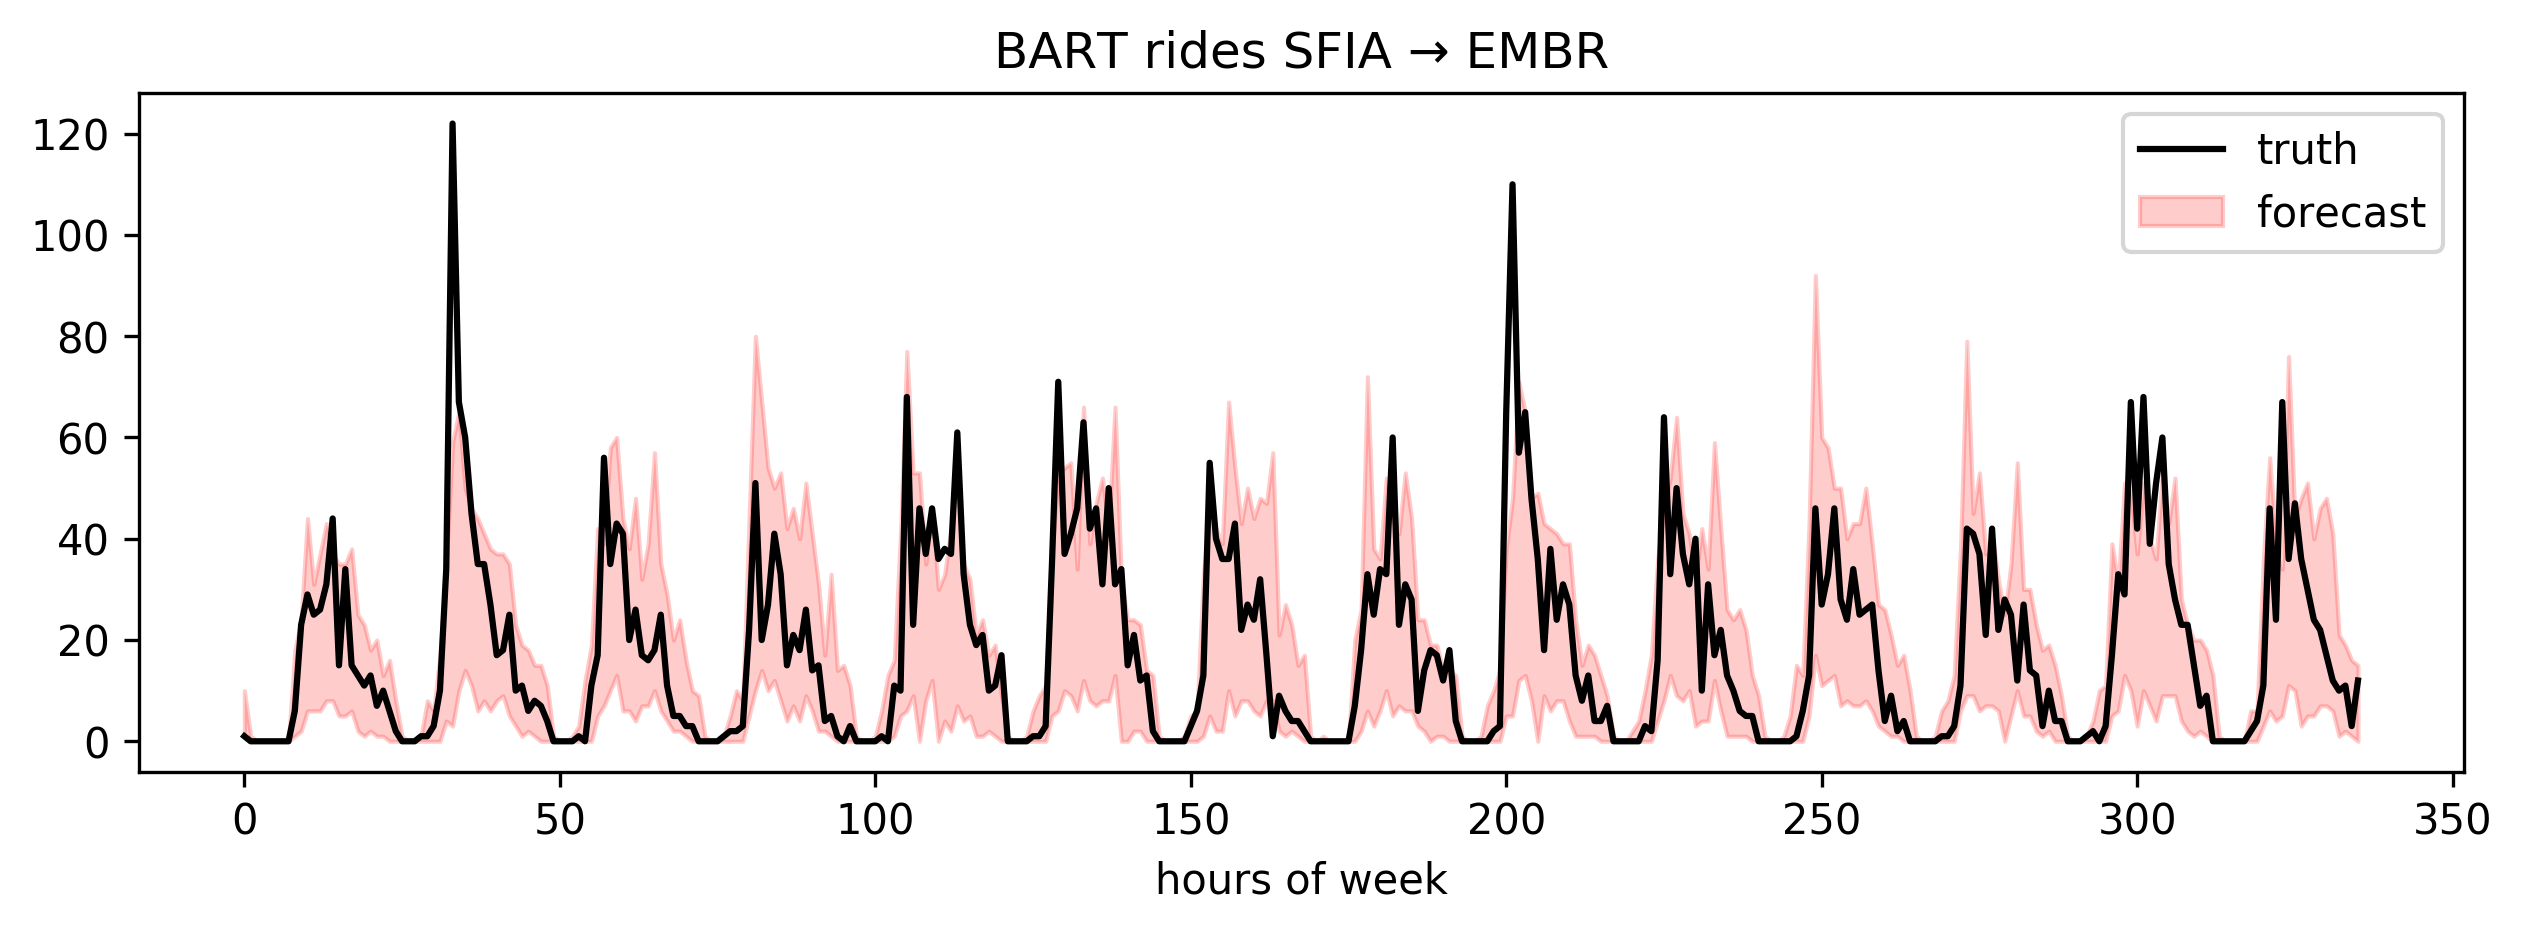

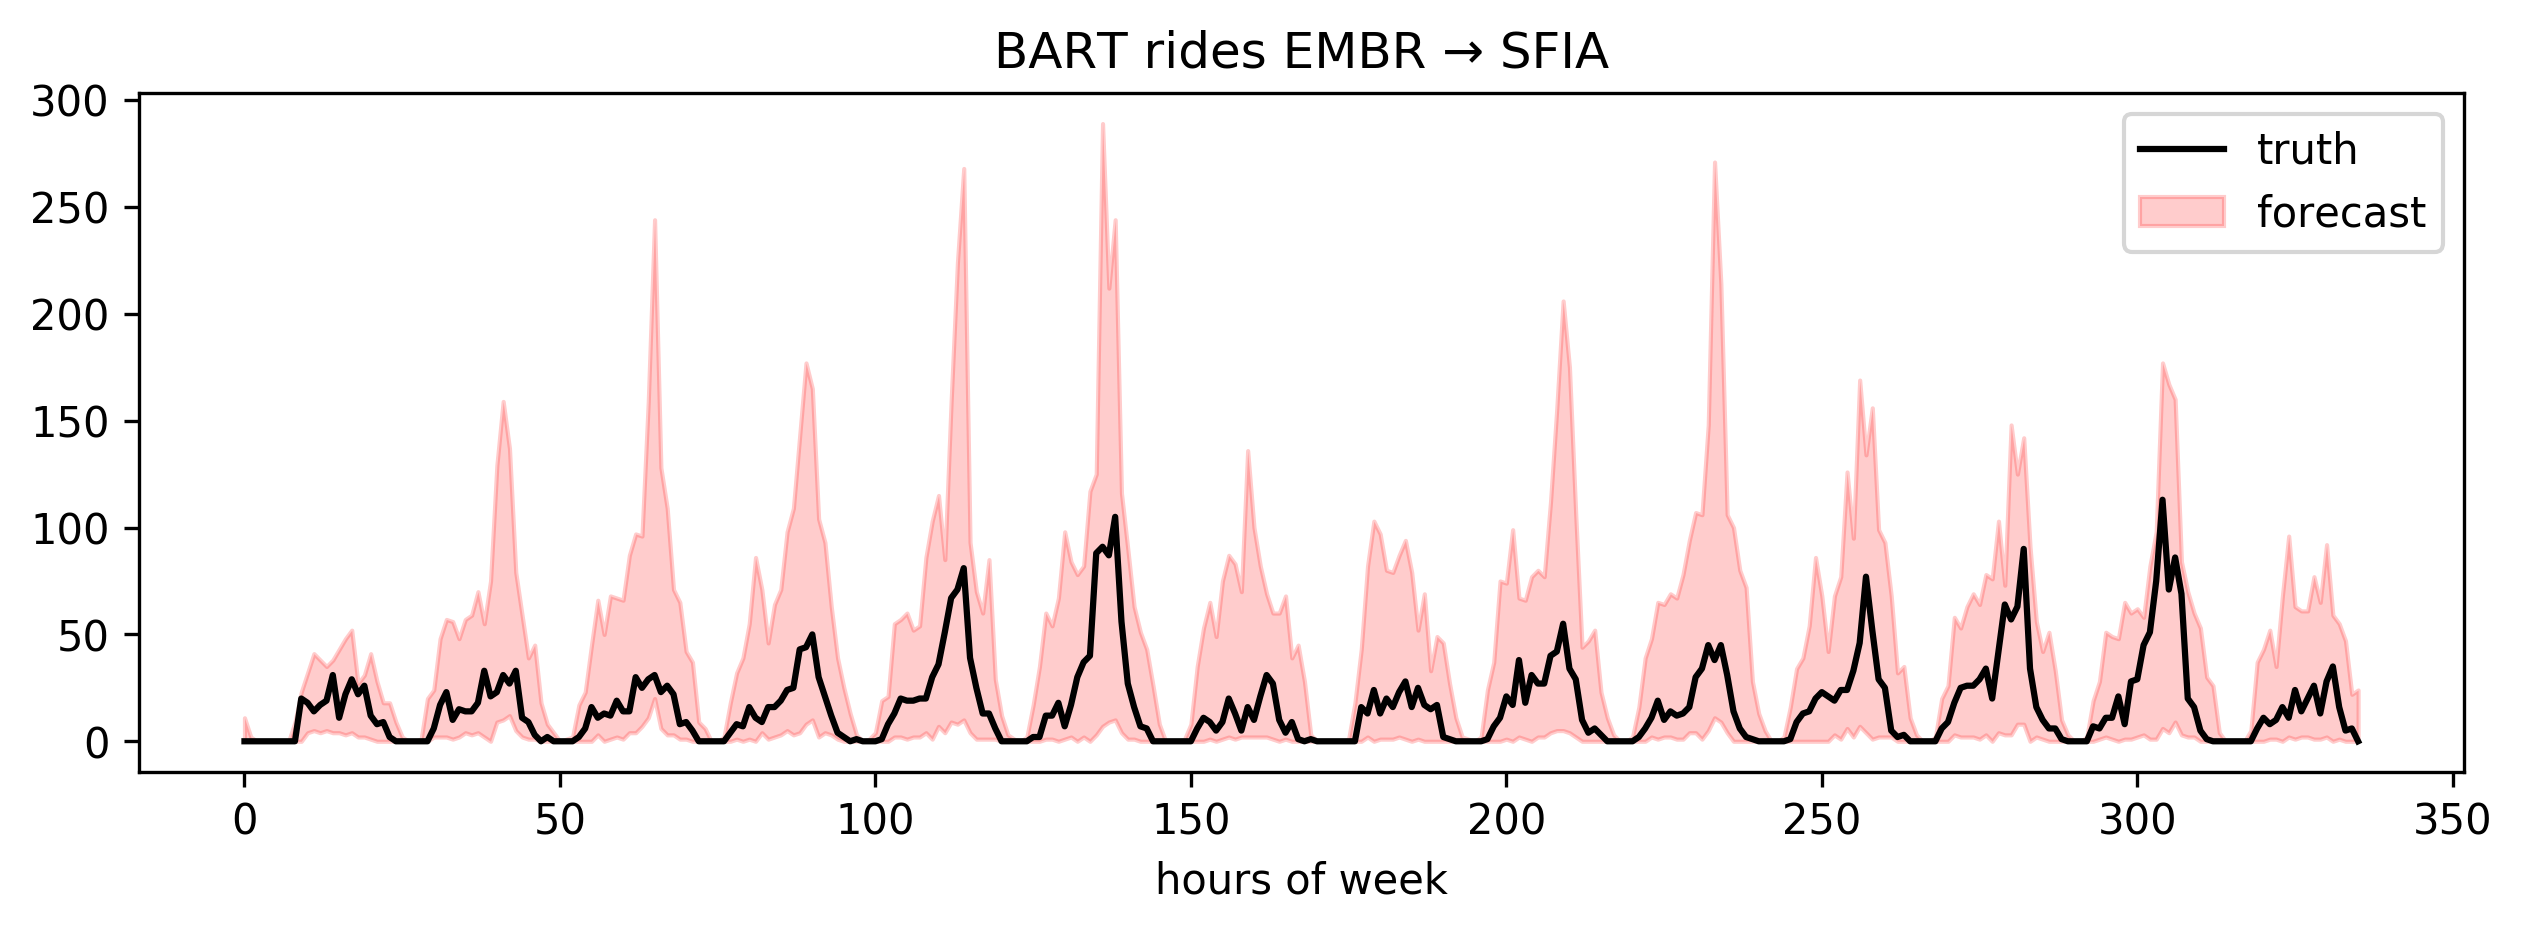

In [8]:
for origin, destin in [("SFIA", "EMBR"), ("EMBR", "SFIA")]:
    o = forecaster.dataset["stations"].index(origin)
    d = forecaster.dataset["stations"].index(destin)
    low = samples[:, :, o, d].kthvalue(10, dim=0)[0]
    high = samples[:, :, o, d].kthvalue(90, dim=0)[0]
    pyplot.figure(figsize=(10, 3), dpi=300)
    pyplot.plot(truth[:, o, d], 'k-', label="truth")
    pyplot.fill_between(torch.arange(len(low)), low, high,
                        color='red', alpha=0.2, label="forecast")
    pyplot.xlabel("hours of week")
    pyplot.title("BART rides {} → {}".format(origin, destin))
    pyplot.legend();